<a href="https://colab.research.google.com/github/Bosy-Ayman/DSAI-456-Speech/blob/main/assignment6_speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import librosa
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from scipy.io import wavfile
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import kagglehub

# 1. CTC Forward Algorithm


In [ ]:
class CTCLoss:
    def __init__(self, blank=0):
        self.blank = blank

    def forward(self, logits, targets, input_lengths, target_lengths):
        T, N, C = logits.shape
        loss = 0.0

        for n in range(N):
            t_len = input_lengths[n]
            y_len = target_lengths[n]

            alphas = self._compute_alphas(logits[:t_len, n, :], targets[n, :y_len], C)

            prob = alphas[t_len - 1, 2 * y_len - 1] + alphas[t_len - 1, 2 * y_len] + 1e-10

            loss += -np.log(prob)

        return loss / N

    def _compute_alphas(self, logits, target, C):
        T, _ = logits.shape
        L = len(target)

        # Insert blanks between phonemes: blank, y 0, blank, y1, blank, ...
        extended_target = np.zeros(2 * L + 1, dtype=int)
        extended_target[1::2] = target

        alphas = np.zeros((T, 2 * L + 1))

        #[1] Initialize first frame --> whether it could be a blank OR a character
        alphas[0, 0] = logits[0, self.blank]
        if L > 0:
            alphas[0, 1] = logits[0, target[0]]

        # Forward pass
        for t in range(1, T):
            for s in range(2 * L + 1):
                char = extended_target[s]

                # Case A: Standard Transition (Stay or Step)
                alpha_sum = alphas[t - 1, s]

                # Path 2: from left
                if s > 0:
                    alpha_sum += alphas[t - 1, s - 1]


                # Case B: The "Skip" Transition
                # Path 3: from skip (diagonal, but only for non-blank)
                if s > 1 and extended_target[s] != self.blank and \
                   extended_target[s] != extended_target[s - 2]:
                    alpha_sum += alphas[t - 1, s - 2]

                alphas[t, s] = alpha_sum * logits[t, int(char)]

        return alphas

# 2. CTC Decoding


In [ ]:

class CTCDecoder:
    def __init__(self, blank=0, beam_width=50):
        self.blank = blank
        self.beam_width = beam_width

    def greedy_decode(self, logits):
        preds = np.argmax(logits, axis=1)

        decoded = []
        prev = self.blank

        for p in preds:
            if p != self.blank and p != prev:
                decoded.append(p)
            prev = p

        return np.array(decoded)

    def beam_search_decode(self, logits, beam_width=None):
        if beam_width is None:
            beam_width = self.beam_width

        T, C = logits.shape

        # beams:  (seq , last_char) → (prob_blank, prob_nonblank)
        beams = {("", self.blank): (0.0, 0.0)}

        for t in range(T):
            new_beams = {}

            for (seq, last), (pb, pnb) in beams.items():
                for c in range(C):

                    p = logits[t, c]

                    #ase 1: blank
                    if c == self.blank:
                        new_pb = pb + p
                        key = (seq, last)

                        old_pb, old_pnb = new_beams.get(key, (0.0, 0.0))
                        new_beams[key] = (old_pb + new_pb, old_pnb)

                    # Case 2: non-blank
                    else:
                        # If repeated then continue same char
                        if c == last:
                            new_pnb = pnb + p
                        else:
                            new_pnb = pb + pnb + p

                        new_seq = seq + str(c)
                        key = (new_seq, c)

                        old_pb, old_pnb = new_beams.get(key, (0.0, 0.0))
                        new_beams[key] = (old_pb, old_pnb + new_pnb)

            scored = []
            for (seq, last), (pb, pnb) in new_beams.items():
                score = max(pb, pnb)
                scored.append((seq, last, score))

            scored.sort(key=lambda x: x[2], reverse=True)
            scored = scored[:beam_width]

            # rebuild beams dictionary
            beams = {(seq, last): (score, 0.0) for seq, last, score in scored}

        #  choose best sequence
        best = max(beams.items(), key=lambda x: x[1][0])
        seq = best[0][0]

        return np.array([int(c) for c in seq]) if seq else np.array([])


#  LSTM with CTC


In [ ]:

class CTCModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,batch_first=False, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.num_classes = num_classes

    def forward(self, x):

        lstm_out, _ = self.lstm(x)
        logits = self.fc(lstm_out)
        return logits



# Dataset


In [ ]:
class TIMITDataset(Dataset):
    def __init__(self, wav_files, phone_files, phoneme_to_idx, sr=16000, n_mfcc=13):
        self.wav_files = wav_files
        self.phone_files = phone_files
        self.phoneme_to_idx = phoneme_to_idx
        self.sr = sr
        self.n_mfcc = n_mfcc

    def __len__(self):
        return len(self.wav_files)

    def __getitem__(self, idx):
        wav_file = self.wav_files[idx]
        phone_file = self.phone_files[idx]

        try:
            # audio
            audio, _ = librosa.load(wav_file, sr=self.sr)
            mfcc = librosa.feature.mfcc(y=audio, sr=self.sr, n_mfcc=self.n_mfcc).T

            # phonemes
            phonemes = []
            with open(phone_file) as f:
                for line in f:
                    phonemes.append(line.split()[-1])

            targets = [self.phoneme_to_idx.get(p, 0) for p in phonemes]

        except:

            mfcc = np.zeros((100, self.n_mfcc))
            targets = [1] * 10

        return {
            "features": torch.tensor(mfcc, dtype=torch.float32),
            "targets": torch.tensor(targets, dtype=torch.long),
            "input_length": len(mfcc),
            "target_length": len(targets)
        }



In [ ]:
def collate_batch(batch):
    max_input_len = max(item['input_length'] for item in batch)
    max_target_len = max(item['target_length'] for item in batch)

    features = []
    targets = []
    input_lengths = []
    target_lengths = []

    for item in batch:
        feat = item['features']
        targ = item['targets']

        # Pad features
        pad_len = max_input_len - len(feat)
        feat = torch.cat([feat, torch.zeros(pad_len, feat.shape[1])])
        features.append(feat)


        pad_len = max_target_len - len(targ)
        targ = torch.cat([targ, torch.zeros(pad_len, dtype=targ.dtype)])
        targets.append(targ)

        input_lengths.append(item['input_length'])
        target_lengths.append(item['target_length'])

    return {
        'features': torch.stack(features).transpose(0, 1),
        'targets': torch.stack(targets),
        'input_lengths': torch.tensor(input_lengths),
        'target_lengths': torch.tensor(target_lengths)
    }


In [ ]:
def compute_phoneme_error_rate(predictions, targets):
    errors = 0
    total = 0

    for pred, targ in zip(predictions, targets):
        # Edit distance
        d = np.zeros((len(pred) + 1, len(targ) + 1))
        for i in range(len(pred) + 1):
            d[i, 0] = i
        for j in range(len(targ) + 1):
            d[0, j] = j

        for i in range(1, len(pred) + 1):
            for j in range(1, len(targ) + 1):
                if pred[i-1] == targ[j-1]:
                    d[i, j] = d[i-1, j-1]
                else:
                    d[i, j] = 1 + min(d[i-1, j], d[i, j-1], d[i-1, j-1])

        errors += d[-1, -1]
        total += len(targ)

    return 100 * errors / total if total > 0 else 0


#  Training

In [ ]:
def train_model(model, train_loader, device, epochs=20, lr=0.001):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    ctc_loss_fn = CTCLoss(blank=0)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            features = batch['features'].to(device)
            targets = batch['targets'].to(device)
            input_lengths = batch['input_lengths']
            target_lengths = batch['target_lengths']

            # Forward pass
            logits = model(features)
            logits_np = logits.detach().cpu().numpy()

            # Compute CTC loss
            loss = ctc_loss_fn.forward(logits_np, targets.cpu().numpy(), `input_lengths.numpy(), target_lengths.numpy())

            # Backward pass
            optimizer.zero_grad()

            log_probs = torch.nn.functional.log_softmax(logits, dim=2)
            loss_pytorch = nn.CTCLoss(blank=0, reduction='mean')(log_probs, targets, input_lengths, target_lengths)
            loss_pytorch.backward()
            optimizer.step()

            total_loss += loss_pytorch.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

    return model

In [ ]:
def evaluate_model(model, test_loader, device, idx_to_phoneme):

    model.eval()
    decoder = CTCDecoder(blank=0)

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            features = batch['features'].to(device)
            logits = model(features)
            for n in range(logits.shape[1]):
                log_probs = torch.nn.functional.log_softmax(logits[:, n, :], dim=1)


                pred = decoder.greedy_decode(log_probs.cpu().numpy())
                all_predictions.append(pred)

                # Target
                target = batch['targets'][n, :batch['target_lengths'][n]].numpy()
                all_targets.append(target)

    per = compute_phoneme_error_rate(all_predictions, all_targets)
    return per, all_predictions, all_targets


In [ ]:
def visualize_alignment(model, sample_features, sample_target, device, idx_to_phoneme):
    model.eval()

    with torch.no_grad():
        features = sample_features.unsqueeze(1).to(device)
        logits = model(features)
        log_probs = torch.nn.functional.log_softmax(logits[:, 0, :], dim=1)

    log_probs_np = log_probs.cpu().numpy()

    fig, (ax1) = plt.subplots( figsize=(14, 6))

    # Plot log probabilities heatmap
    im = ax1.imshow(log_probs_np.T, aspect='auto', cmap='viridis', origin='lower')
    ax1.set_ylabel('Phoneme Index')
    ax1.set_xlabel('Time Frame')
    ax1.set_title('CTC Log Probabilities Over Time')
    plt.colorbar(im, ax=ax1)



In [ ]:
def load_timit_files(dataset_path):

    wav_files = []
    phone_files = []

    timit_root = Path(dataset_path)

    all_wavs = list(timit_root.rglob("*.WAV"))
    print(f"Found {len(all_wavs)} WAV files")


    for wav_file in sorted(all_wavs):
        base_name = wav_file.stem
        phone_file = wav_file.parent / f"{base_name}.PHN"

        if phone_file.exists():
            wav_files.append(str(wav_file))
            phone_files.append(str(phone_file))

    if wav_files:
        print(f"Successfully found {len(wav_files)} audio-phoneme pairs")
        print(f"Sample files:")
        for w, p in list(zip(wav_files, phone_files))[:3]:
            print(f"  Audio: {Path(w).name}")
            print(f"  Phone: {Path(p).name}")
        return wav_files, phone_files




In [ ]:
def extract_phonemes_from_file(phone_file):
    phonemes = []
    try:
        with open(phone_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 3:

                    phonemes.append(parts[2])
    except Exception as e:
        print(f"Error reading {phone_file}: {e}")

    return phonemes

In [ ]:
SR = 16000
N_MFCC = 13
HIDDEN_SIZE = 256
NUM_LAYERS = 2
BATCH_SIZE = 16
EPOCHS = 10



In [ ]:
dataset_path = kagglehub.dataset_download("mfekadu/darpa-timit-acousticphonetic-continuous-speech")
print(f"Dataset path: {dataset_path}")


Using Colab cache for faster access to the 'darpa-timit-acousticphonetic-continuous-speech' dataset.
Dataset path: /kaggle/input/darpa-timit-acousticphonetic-continuous-speech


In [ ]:
print("Loading TIMIT files...")
wav_files, phone_files = load_timit_files(dataset_path)
print(f"Found {len(wav_files)} audio files")


Loading TIMIT files...
Found 6300 WAV files
Successfully found 6300 audio-phoneme pairs
Sample files:
  Audio: SA1.WAV
  Phone: SA1.PHN
  Audio: SA2.WAV
  Phone: SA2.PHN
  Audio: SI1573.WAV
  Phone: SI1573.PHN
Found 6300 audio files


# Extract and build phoneme vocabulary


In [ ]:
phoneme_set = set()
for pf in phone_files[:1000]:
      phonemes = extract_phonemes_from_file(pf)
      phoneme_set.update(phonemes)

phoneme_to_idx = {'': 0}
idx_to_phoneme = {0: ''}
for idx, p in enumerate(sorted(phoneme_set), start=1):
        phoneme_to_idx[p] = idx
        idx_to_phoneme[idx] = p

NUM_CLASSES = len(phoneme_to_idx)
print(f"Number of phoneme classes: {NUM_CLASSES}")
print(f"Phonemes: {sorted(phoneme_set)}")


Number of phoneme classes: 62
Phonemes: ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ax-h', 'axr', 'ay', 'b', 'bcl', 'ch', 'd', 'dcl', 'dh', 'dx', 'eh', 'el', 'em', 'en', 'eng', 'epi', 'er', 'ey', 'f', 'g', 'gcl', 'h#', 'hh', 'hv', 'ih', 'ix', 'iy', 'jh', 'k', 'kcl', 'l', 'm', 'n', 'ng', 'nx', 'ow', 'oy', 'p', 'pau', 'pcl', 'q', 'r', 's', 'sh', 't', 'tcl', 'th', 'uh', 'uw', 'ux', 'v', 'w', 'y', 'z', 'zh']


# Split data


In [ ]:

total_files = len(wav_files)
train_split = int(0.7 * total_files)
dev_split = int(0.85 * total_files)


In [ ]:

train_wav = wav_files[:train_split]
train_phone = phone_files[:train_split]

dev_wav = wav_files[train_split:dev_split]
dev_phone = phone_files[train_split:dev_split]

test_wav = wav_files[dev_split:]
test_phone = phone_files[dev_split:]

print(f"\nData split:")
print(f"  Training: {len(train_wav)} samples")
print(f"  eval: {len(dev_wav)} samples")
print(f"  Test: {len(test_wav)} samples")



Data split:
  Training: 4410 samples
  eval: 945 samples
  Test: 945 samples


# Create datasets


In [ ]:
train_dataset = TIMITDataset(train_wav, train_phone, phoneme_to_idx, sr=SR, n_mfcc=N_MFCC)
dev_dataset = TIMITDataset(dev_wav, dev_phone, phoneme_to_idx, sr=SR, n_mfcc=N_MFCC)
test_dataset = TIMITDataset(test_wav, test_phone, phoneme_to_idx, sr=SR, n_mfcc=N_MFCC)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,collate_fn=collate_batch, num_workers=0)
val_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=False,collate_fn=collate_batch, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,collate_fn=collate_batch, num_workers=0)

# Initialize model


In [ ]:
model = CTCModel(input_size=N_MFCC, hidden_size=HIDDEN_SIZE,
                    num_classes=NUM_CLASSES, num_layers=NUM_LAYERS)

print(f"Model: {model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")


Model: CTCModel(
  (lstm): LSTM(13, 256, num_layers=2, bidirectional=True)
  (fc): Linear(in_features=512, out_features=62, bias=True)
)
Total parameters: 2,163,774


In [ ]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
print("\nTraining ")
model = train_model(model, train_loader, DEVICE, epochs=EPOCHS, lr=0.001)

dev_per, _, _ = evaluate_model(model, dev_loader, DEVICE, idx_to_phoneme)
print(f"PER: {dev_per:.2f}%")



Training 


Epoch 1:   1%|          | 2/276 [00:00<01:47,  2.56it/s]/tmp/ipython-input-85370226.py:17: RuntimeWarning: invalid value encountered in log
  loss += -np.log(prob)
Epoch 1: 100%|██████████| 276/276 [01:55<00:00,  2.40it/s]


Epoch 1/10, Loss: 3.0770


Epoch 2: 100%|██████████| 276/276 [01:55<00:00,  2.40it/s]


Epoch 2/10, Loss: 1.7850


Epoch 3: 100%|██████████| 276/276 [01:56<00:00,  2.36it/s]


Epoch 3/10, Loss: 1.4642


Epoch 4: 100%|██████████| 276/276 [02:01<00:00,  2.27it/s]


Epoch 4/10, Loss: 1.3031


Epoch 5: 100%|██████████| 276/276 [01:56<00:00,  2.36it/s]


Epoch 5/10, Loss: 1.1939


Epoch 6: 100%|██████████| 276/276 [01:54<00:00,  2.40it/s]


Epoch 6/10, Loss: 1.1058


Epoch 7: 100%|██████████| 276/276 [01:56<00:00,  2.37it/s]


Epoch 7/10, Loss: 1.0347


Epoch 8: 100%|██████████| 276/276 [01:56<00:00,  2.38it/s]


Epoch 8/10, Loss: 0.9756


Epoch 9: 100%|██████████| 276/276 [01:56<00:00,  2.37it/s]


Epoch 9/10, Loss: 0.9188


Epoch 10: 100%|██████████| 276/276 [01:56<00:00,  2.37it/s]


Epoch 10/10, Loss: 0.8699


Evaluating: 100%|██████████| 60/60 [00:11<00:00,  5.44it/s]


PER: 40.33%


In [ ]:
test_per, test_preds, test_targets = evaluate_model(model, test_loader, DEVICE, idx_to_phoneme)
print(f"Test PER: {test_per:.2f}%")

Evaluating: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]


Test PER: 39.55%


# Visualize sample alignment


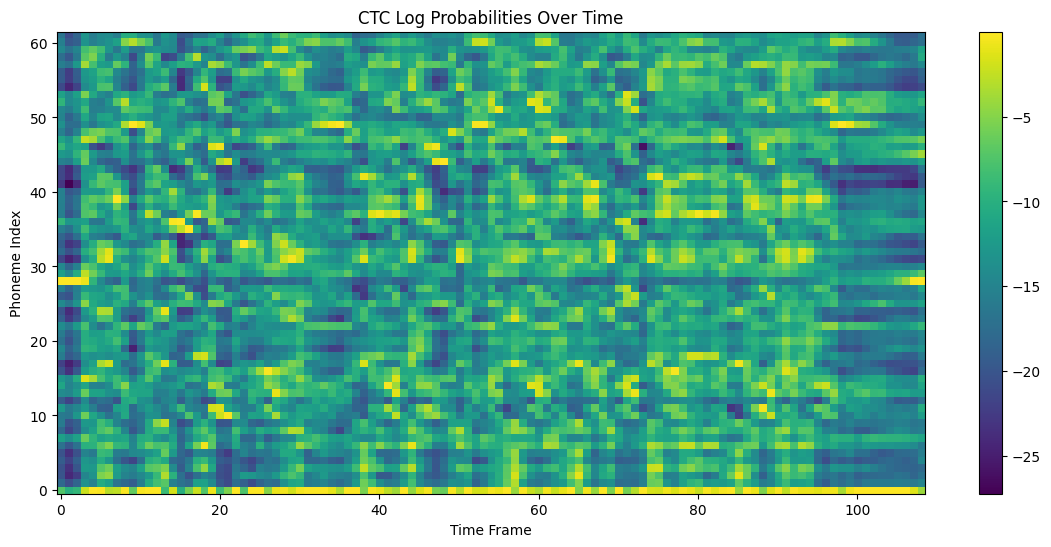

In [ ]:

sample_idx = 0
sample_features = test_dataset[sample_idx]['features']
sample_target = test_dataset[sample_idx]['targets']
visualize_alignment(model, sample_features, sample_target, DEVICE, idx_to_phoneme)


In [ ]:
print("\n Sample Predictions ")
for i in range(min(5, len(test_preds))):
    pred_phonemes = [idx_to_phoneme[int(p)] for p in test_preds[i] if p in idx_to_phoneme]
    target_phonemes = [idx_to_phoneme[int(t)] for t in test_targets[i] if t in idx_to_phoneme]
    print(f"Sample {i+1}:")
    print(f"  Predicted: {' '.join(pred_phonemes)}")
    print(f"  Target:    {' '.join(target_phonemes)}")


 Sample Predictions 
Sample 1:
  Predicted: h# ih n s ey kcl k l ax pcl b iy dx ih s ow l dcl l ax n p ih s t ae dcl d q ae n ih th d ow dx l l ae m bcl d ih n tcl s h# aw th h# jh
  Target:    h# q eh n s ay kcl k l ax pcl p iy dx iy ix z s ah l dh ax m pcl p r ix z eh n tcl t q ae n ih kcl d ow dcl d uh l q eh v ix dx eh n tcl t s h#
Sample 2:
  Predicted: h# ey dcl dx pcl dh ih n s ow el tcl ch r oy s ix z ix n dh ah th ax s ah pcl p ax pcl p ay nx axr dx iy z h# jh
  Target:    h# q ay gcl g ey v dh ih m s eh v el tcl ch oy s ix z en l ah tcl dh ax m epi s eh tcl dh ax pcl p r ay ao r ix dx iy z h#
Sample 3:
  Predicted: h# t ow f w m ey f axr pcl p r aa s ix s s oy bcl b iy n z h# aw th h# jh
  Target:    h# t ow f uw ih z epi m ey dcl f ax m pcl p r aa s eh s tcl s oy bcl b iy n z h#
Sample 4:
  Predicted: h# ih s epi l ow dcl dh ax r ow s epi m aa r sh m ow ax z ah nx ih gcl g ae s pcl p er dx axr h# aw th h# jh
  Target:    h# q ih tcl t s f ah n d ix v r ow s tcl m aa r sh ep